In this notebook, we will build a 3D map of a scene from a small set of images and then localize an image downloaded from the Internet. This demo was contributed by [Philipp Lindenberger](https://github.com/Phil26AT/).

In [1]:
!pip install kaggle

In [2]:
# Acessar o Kaggle por meio do token do usuário
# Entre no Kaggle, vá em seu perfil => Settings > API > Creating New Token
# Um download do arquivo kaggle.json será iniciado em sua máquina
# Carregue aqui este arvo

from google.colab import files
files.upload() #enviar o arquivo kaggle.json

#antes de importar o dataset nós iremos provisionar o local de armazenamento
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
#Alterar a permissão para evitar o aviso durante a partida da ferramenta Kaggle
# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

#Aceitar a competição e copiar o endereço da API para o download do dataset
!kaggle competitions download -c image-matching-challenge-2022

#Descompactar o arquivo baixado
!unzip \*.zip  && rm *.zip




A saída de streaming foi truncada nas últimas 5000 linhas.
  inflating: train/buckingham_palace/images/42572558_3847795752.jpg  
  inflating: train/buckingham_palace/images/43210627_10009473243.jpg  
  inflating: train/buckingham_palace/images/43583354_7506898338.jpg  
  inflating: train/buckingham_palace/images/43641758_9015255137.jpg  
  inflating: train/buckingham_palace/images/43728242_3176119914.jpg  
  inflating: train/buckingham_palace/images/43847879_5656257946.jpg  
  inflating: train/buckingham_palace/images/44446238_9117834424.jpg  
  inflating: train/buckingham_palace/images/44573130_5715131949.jpg  
  inflating: train/buckingham_palace/images/44579495_1325305773.jpg  
  inflating: train/buckingham_palace/images/44944081_6780023064.jpg  
  inflating: train/buckingham_palace/images/45136306_6779959250.jpg  
  inflating: train/buckingham_palace/images/45439163_5667030438.jpg  
  inflating: train/buckingham_palace/images/45955845_8872058158.jpg  
  inflating: train/buckingham_

In [3]:
# Verificando e imprimindo uma lista dos grupos de pastas de monumentos do diretório.

import os
#src = '../input/image-matching-challenge-2022/train'
src = 'train'
val_scenes = []
for f in os.scandir(src):
    if f.is_dir():
        cur_scene = os.path.split(f)[-1]
        print(f'Found scene "{cur_scene}"" at {f.path}')
        val_scenes += [cur_scene]

Found scene "taj_mahal"" at train/taj_mahal
Found scene "piazza_san_marco"" at train/piazza_san_marco
Found scene "lincoln_memorial_statue"" at train/lincoln_memorial_statue
Found scene "notre_dame_front_facade"" at train/notre_dame_front_facade
Found scene "sagrada_familia"" at train/sagrada_familia
Found scene "st_pauls_cathedral"" at train/st_pauls_cathedral
Found scene "sacre_coeur"" at train/sacre_coeur
Found scene "buckingham_palace"" at train/buckingham_palace
Found scene "brandenburg_gate"" at train/brandenburg_gate
Found scene "temple_nara_japan"" at train/temple_nara_japan
Found scene "st_peters_square"" at train/st_peters_square
Found scene "grand_place_brussels"" at train/grand_place_brussels
Found scene "trevi_fountain"" at train/trevi_fountain
Found scene "colosseum_exterior"" at train/colosseum_exterior
Found scene "pantheon_exterior"" at train/pantheon_exterior
Found scene "british_museum"" at train/british_museum


In [4]:
import cv2
import imghdr

#removendo fotos com extensões não compativeis
data_dir = 'train'

image_exts = ['jpeg', 'jpg', 'bmp', 'png']

for image_class in os.listdir(data_dir):#percorrendo todas as pastas
  if os.path.isdir(image_class):
   for image in os.listdir(os.path.join(data_dir, image_class)): #percorrendo todas as fotos de todas as pastas
     image_path = os.path.join(data_dir,image_class,image)

     try:
       img = cv2.imread(image_path)
       tip = imghdr.what(image_path)
       if tip not in image_exts:
         print("Imagem não está na extensao certa{}".format(image_path))
         os.remove(image_path)
     except Exception as e:
       print("Problema com a imagem{}".format(image_path))

In [5]:
# Utilizaremos as funções de construção disponíveis no repositório de Localização Hierárquica do GitHub
# Foi uma solução desenvolvida por Paul Sarlin com Philipp Lindenberger

# Este processo é um pouco demorado (2 a 4 min em média). Tenha paciênciaaa! Rrrs
!git clone --quiet --recursive https://github.com/cvg/Hierarchical-Localization/
!rm -rf /content/Hierarchical-Localization/datasets
%cd Hierarchical-Localization

!pip install --progress-bar off --quiet -e .
!pip install --progress-bar off --quiet --upgrade plotly


#import hloc
import tqdm, tqdm.notebook
tqdm.tqdm = tqdm.notebook.tqdm  # notebook-friendly progress bars
from pathlib import Path

from hloc import extract_features, match_features, reconstruction, visualization, pairs_from_exhaustive
from hloc.visualization import plot_images, read_image
from hloc.utils import viz_3d

/content/Hierarchical-Localization
  Preparing metadata (setup.py) ... done
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [6]:
# Escolha dentre a lista de pastas, uma que contem o monumento a ser criada a representação 3D.
#images = Path('datasets/sacre_coeur')
images = Path('/content/train/colosseum_exterior')

In [7]:
# Setup
# Aqui definiremos as saídas das features necessárias para criação da representação 3D
# Será utilizada as ferramentas SuperPoint local features com SuperGlue matcher

outputs = Path('outputs/demo/')
#!rm -rf $outputs
sfm_pairs = outputs / 'pairs-sfm.txt'
loc_pairs = outputs / 'pairs-loc.txt'
sfm_dir = outputs / 'sfm'
features = outputs / 'features.h5'
matches = outputs / 'matches.h5'

feature_conf = extract_features.confs['disk']
matcher_conf = match_features.confs['disk+lightglue']

/content/train/colosseum_exterior
10 mapping images


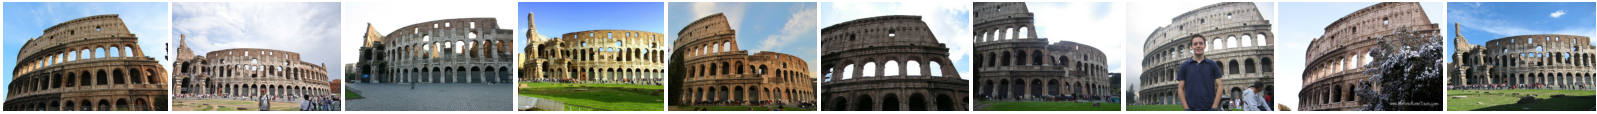

In [8]:
# Mapeamento 3D
# Será listado algumas imagens para que se veja que as imagens correspondem ao monumento selecionado

#import os
import random
print(images)

# Serão mostradas apenas 10 imagens. A medida que se aumenta o número de imagens, o tempo aumenta praticamente de forma exponencial.
# Por isso, a título de exemplo e para demonstração do desafio, usaremos apenas 10 imagens do banco, selecionadas de forma aleatória.
# Porém, o banco foi utilizado de maneira completa no modelo de rede neural para classificação
references = random.sample([str(p.relative_to(images)) for p in (images / 'images').iterdir()],10) # Imagens do objeto selecionadas de forma aleatória no diretório

# Imprimindo a quantidade de imagens a serem utilizadas. Confirmando as 10 acionadas
print(len(references), "mapping images")

# Set the backend
plot_images([read_image(images / r) for r in references], dpi=25)

In [9]:
# Será extraída as característias das imagens enviadas, verificando as similaridades par a par. É feita uma combinação do total de imagens enviadas, agrupadas 2 a 2
# Este processo é um pouco demorado (5 a 10 min em média. Dependendo do ambiente, até 20 min). Tenha paciênciaaa! Rrrs

extract_features.main(feature_conf, images, image_list=references, feature_path=features)
pairs_from_exhaustive.main(sfm_pairs, image_list=references)
match_features.main(matcher_conf, sfm_pairs, features=features, matches=matches);

[2024/04/27 14:24:56 hloc INFO] Extracting local features with configuration:
{'model': {'max_keypoints': 5000, 'name': 'disk'},
 'output': 'feats-disk',
 'preprocessing': {'grayscale': False, 'resize_max': 1600}}
Downloading: "https://raw.githubusercontent.com/cvlab-epfl/disk/master/depth-save.pth" to /root/.cache/torch/hub/checkpoints/depth-save.pth


  0%|          | 0.00/4.17M [00:00<?, ?B/s]

  0%|          | 0/10 [00:00<?, ?it/s]

[2024/04/27 14:26:45 hloc INFO] Finished exporting features.
[2024/04/27 14:26:45 hloc INFO] Found 45 pairs.
[2024/04/27 14:26:45 hloc INFO] Matching local features with configuration:
{'model': {'features': 'disk', 'name': 'lightglue'},
 'output': 'matches-disk-lightglue'}
Downloading: "https://github.com/cvg/LightGlue/releases/download/v0.1_arxiv/disk_lightglue.pth" to /root/.cache/torch/hub/checkpoints/disk_lightglue_v0-1_arxiv.pth


  0%|          | 0.00/45.4M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 5 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/45 [00:00<?, ?it/s]

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
[2024/04/27 14:49:39 hloc INFO] Finished exporting matches.


The we run incremental Structure-from-Motion...

In [10]:
model = reconstruction.main(sfm_dir, images, sfm_pairs, features, matches, image_list=references)

[2024/04/27 14:49:39 hloc INFO] Creating an empty database...
[2024/04/27 14:49:39 hloc INFO] Importing images into the database...
[2024/04/27 14:49:39 hloc INFO] Importing features into the database...


  0%|          | 0/10 [00:00<?, ?it/s]

[2024/04/27 14:49:39 hloc INFO] Importing matches into the database...


  0%|          | 0/45 [00:00<?, ?it/s]

[2024/04/27 14:49:39 hloc INFO] Performing geometric verification of the matches...
[2024/04/27 14:49:42 hloc INFO] Running 3D reconstruction...
[2024/04/27 14:50:11 hloc INFO] Reconstructed 1 model(s).
[2024/04/27 14:50:11 hloc INFO] Largest model is #0 with 10 images.
[2024/04/27 14:50:11 hloc INFO] Reconstruction statistics:
Reconstruction:
	num_reg_images = 10
	num_cameras = 10
	num_points3D = 7908
	num_observations = 32808
	mean_track_length = 4.14871
	mean_observations_per_image = 3280.8
	mean_reprojection_error = 0.754875
	num_input_images = 10


and display the reconstructed 3D model:

In [11]:
fig = viz_3d.init_figure()
viz_3d.plot_reconstruction(fig, model, color='rgba(255,0,0,0.5)', name="mapping", points_rgb=True)
fig.show()

We also visualize which keypoints were triangulated into the 3D model.

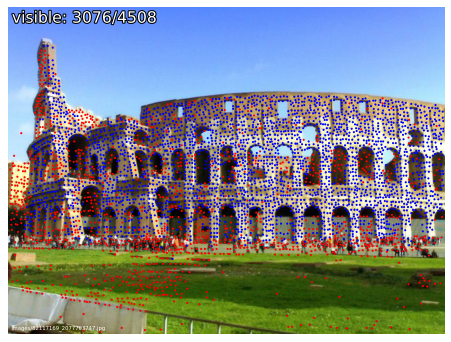

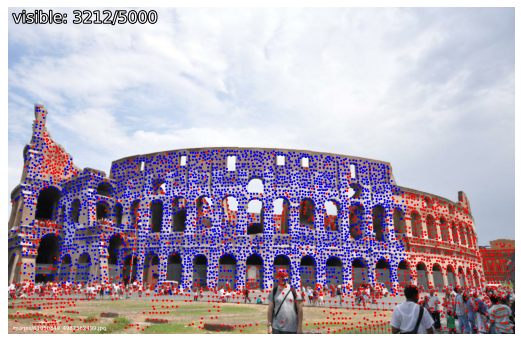

In [12]:
visualization.visualize_sfm_2d(model, images, color_by='visibility', n=2)